In [1]:
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [2]:
def rgb2gray(img):
    gray = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    return gray


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(32, 32, 1)


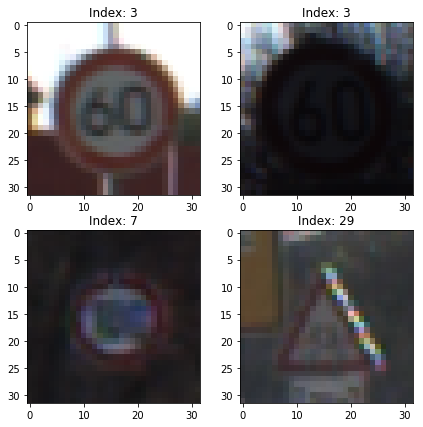

In [3]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.copy(y_train)
n_classes = len(set(n_classes))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

t_i = []
img = []
for i in range(4):
    t_i.append(random.randint(0, len(X_train)))
    img.append(X_train[t_i[-1]].squeeze())

fig = plt.figure(figsize=(7,7))
for i in range(4):
    sf = fig.add_subplot(2, 2, i+1)
    plt.imshow(img[i], cmap="gray")
    sf.set_title("Index: "+str(y_train[t_i[i]]))

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

X_train = [rgb2gray(img).reshape((32,32,1)) for img in X_train]
X_valid = [rgb2gray(img).reshape((32,32,1)) for img in X_valid]
X_test = [rgb2gray(img).reshape((32,32,1)) for img in X_test]
X_train, y_train = shuffle(X_train, y_train)

#plt.imshow(X_train[0])
print(X_train[0].shape)

In [4]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def model(x):
    mu = 0
    sigma = 0.1
    keep_prob = 0.75
    weights = {
        "cnv1": tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma)),
        "cnv2": tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 32), mean = mu, stddev = sigma)),
        #"cnv3": tf.Variable(tf.truncated_normal(shape=(3, 3, 16, 16), mean = mu, stddev = sigma)),
        #"cnv4": tf.Variable(tf.truncated_normal(shape=(1, 1, 32, 64), mean = mu, stddev = sigma)),
        "cnv3": tf.Variable(tf.truncated_normal(shape=(2048, 512), mean = mu, stddev = sigma)),
        "cnv4": tf.Variable(tf.truncated_normal(shape=(512, 172), mean = mu, stddev = sigma)),
        "cnv5": tf.Variable(tf.truncated_normal(shape=(172, n_classes), mean = mu, stddev = sigma))
    }
    biases = {
        'bcv1': tf.Variable(tf.zeros([16])),
        'bcv2': tf.Variable(tf.zeros([32])),
        #'bcv3': tf.Variable(tf.zeros([16])),
        #'bcv4': tf.Variable(tf.zeros([64])),
        'bcv3': tf.Variable(tf.zeros([512])),
        'bcv4': tf.Variable(tf.zeros([172])),
        'bcv5': tf.Variable(tf.zeros([n_classes]))
    }
    # Layer 1: Convolutional. Input=32x32x1, Output = 32x32x16
    layer = tf.nn.conv2d(x, weights['cnv1'], strides=[1,1,1,1], padding="SAME") + biases['bcv1']
    layer = tf.nn.relu(layer)
    #Pooling, Input = 32x32x32, Output = 16x16x32
    #layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # Layer 2: Convolutional. Input=32x32x16, Output = 16x16x32
    layer = tf.nn.conv2d(layer, weights['cnv2'], strides=[1,2,2,1], padding="SAME") + biases['bcv2']
    layer = tf.nn.relu(layer)
    #Pooling, Input = 16x16x32, Output = 8x8x32
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    #flatten the image, output = 2048
    layer = flatten(layer)
    layer = tf.nn.dropout(layer, keep_prob) #keep_prob = 0.7
    
    #Layer 3: Fully connected Input = 2048, Output = 512
    layer = tf.add(tf.matmul(layer, weights['cnv3']), biases['bcv3'])
    layer = tf.nn.relu(layer)
    
    #Layer 4: Fully connected Input = 512, Output = 172
    layer = tf.add(tf.matmul(layer, weights['cnv4']), biases['bcv4'])
    layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 0.8)
    
    #Layer 5: Fully connected Input = 172, Output = 43
    layer = tf.add(tf.matmul(layer, weights['cnv5']), biases['bcv5'])
    logits = tf.nn.relu(layer)
    return logits

In [5]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.000381
EPOCHS = 100
BATCH_SIZE = 128
#dropout = 0.80

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './model')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.057

EPOCH 2 ...
Validation Accuracy = 0.056

EPOCH 3 ...
Validation Accuracy = 0.056

EPOCH 4 ...
Validation Accuracy = 0.056

EPOCH 5 ...
Validation Accuracy = 0.059

EPOCH 6 ...
Validation Accuracy = 0.145

EPOCH 7 ...
Validation Accuracy = 0.273

EPOCH 8 ...
Validation Accuracy = 0.413

EPOCH 9 ...
Validation Accuracy = 0.532

EPOCH 10 ...
Validation Accuracy = 0.612

EPOCH 11 ...
Validation Accuracy = 0.681

EPOCH 12 ...
Validation Accuracy = 0.732

EPOCH 13 ...
Validation Accuracy = 0.753

EPOCH 14 ...
Validation Accuracy = 0.807

EPOCH 15 ...
Validation Accuracy = 0.810

EPOCH 16 ...
Validation Accuracy = 0.838

EPOCH 17 ...
Validation Accuracy = 0.841

EPOCH 18 ...
Validation Accuracy = 0.855

EPOCH 19 ...
Validation Accuracy = 0.863

EPOCH 20 ...
Validation Accuracy = 0.876

EPOCH 21 ...
Validation Accuracy = 0.878

EPOCH 22 ...
Validation Accuracy = 0.884

EPOCH 23 ...
Validation Accuracy = 0.897

EPOCH 24 ...
Validation Accura